In [154]:
import numpy as np
import matplotlib.image as mpimg
import cv2
import glob


from keras.models import Sequential
from keras.layers import Lambda, Conv2D, Input, LeakyReLU, MaxPooling2D, Dropout, Dense, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
cars = glob.glob('./data/vehicles/GTI_Far/*')
cars.extend(glob.glob('./data/vehicles/GTI_MiddleClose/*'))
cars.extend(glob.glob('./data/vehicles/GTI_Right/*'))
cars.extend(glob.glob('./data/vehicles/KITTI_extracted/*'))
# cars.extend(glob.glob('./data/udacity_car_extracted/*')[:500])

notcars = glob.glob('./data/non-vehicles/GTI/*')
notcars.extend(glob.glob('./data/non-vehicles/Extras/*'))
# notcars.extend(glob.glob('./data/udacity_notcar_extracted/*'))



# # get a small sample for test
# cars = cars[:500]
# notcars = notcars[:2000]


print('Number of vehicle images: ', len(cars), '  image shape: ', mpimg.imread(cars[0]).shape)
print('Number of non-vehicle images: ', len(notcars), '  image shape: ', mpimg.imread(notcars[0]).shape)

Number of vehicle images:  7883   image shape:  (64, 64, 3)
Number of non-vehicle images:  8968   image shape:  (64, 64, 3)


In [57]:
car_features = [] # list of 64*64 images
notcar_features = []

for img in cars:
    car_img = mpimg.imread(img)
    car_resized = cv2.resize(car_img, (64, 64))
    car_features.append(car_resized)

for img in notcars:
    notcar_img = mpimg.imread(img)
    notcar_resized = cv2.resize(notcar_img, (64, 64))
    notcar_features.append(notcar_resized)

assert len(car_features) == len(cars)
assert len(notcar_features) == len(notcars)

In [99]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
y = to_categorical(y)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

In [100]:
model = Sequential()

### preprocessing layer
# normalisation and centraling
# model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(64,64,3)))

model.add(Conv2D(8, kernel_size=5, strides=(2, 2), kernel_initializer='random_uniform', input_shape=(64,64,3)))


# conv1
# model.add(Conv2D(8, kernel_size=5, strides=(2, 2), kernel_initializer='random_uniform'))
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Conv2D(16, kernel_size=5, strides=(1, 1), kernel_initializer='random_uniform'))
model.add(LeakyReLU())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, kernel_size=3, strides=(1, 1), kernel_initializer='random_uniform'))
model.add(LeakyReLU())
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(1088))
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(LeakyReLU())
model.add(Dropout(0.3))

model.add(Dense(30))
model.add(LeakyReLU())

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')




In [101]:
epochs = 10
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


In [102]:
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])


Train on 10784 samples, validate on 2696 samples
Epoch 1/10
10784/10784 [==============================] - 39s - loss: 0.3691 - val_loss: 0.2117
Epoch 2/10
10784/10784 [==============================] - 35s - loss: 0.1688 - val_loss: 0.1231
Epoch 3/10
10784/10784 [==============================] - 37s - loss: 0.1030 - val_loss: 0.0718
Epoch 4/10
10784/10784 [==============================] - 37s - loss: 0.0632 - val_loss: 0.0477
Epoch 5/10
10784/10784 [==============================] - 35s - loss: 0.0681 - val_loss: 0.0472
Epoch 6/10
10784/10784 [==============================] - 36s - loss: 0.0396 - val_loss: 0.0526
Epoch 7/10
10784/10784 [==============================] - 36s - loss: 0.0327 - val_loss: 0.0457
Epoch 8/10
10784/10784 [==============================] - 35s - loss: 0.0434 - val_loss: 0.0423
Epoch 9/10
10784/10784 [==============================] - 40s - loss: 0.0347 - val_loss: 0.0378
Epoch 10/10
10784/10784 [==============================] - 41s - loss: 0.0314 - val_los

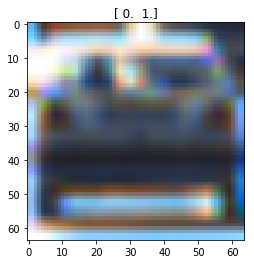

In [117]:
plt.imshow(X_test[0])
plt.title(y_test[0])

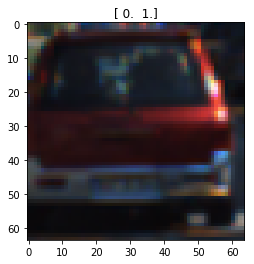

In [118]:
plt.imshow(X_train[0])
plt.title(y_train[0])

In [110]:
loss = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', loss)
# print('Test accuracy:', acc)

3328/3371 [============================>.] - ETA: 0sTest score: 0.0222210915564


In [143]:
class VehicleDetector(object):
    def __init__(self, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale
        self.svc = svc
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
    
    
    
    def find_cars(self, img):

        ystart = self.ystart
        ystop = self.ystop
        scale = self.scale
        svc = self.svc
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        
        draw_img = np.copy(img)
        img = img.astype(np.float32)/255

        img_tosearch = img[ystart:ystop,:,:]
#         ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if scale != 1:
            imshape = img_tosearch.shape
            img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = img_tosearch[:,:,0]
        ch2 = img_tosearch[:,:,1]
        ch3 = img_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

#         # Compute individual channel HOG features for the entire image
#         hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#         hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#         hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
#                 # Extract HOG for this patch
#                 hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#                 hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#                 hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#                 hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                subimg = subimg.reshape((1, subimg.shape[0], subimg.shape[1], subimg.shape[2]))
#                 # Get color features
#                 spatial_features = bin_spatial(subimg, size=spatial_size)
#                 hist_features = color_hist(subimg, nbins=hist_bins)

#                 # Scale features and make a prediction
#                 test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                
                test_prediction = svc.predict(subimg)

                if test_prediction[0][1] > 0.75:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

#                 bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
        return draw_img
    
ystart = 400
ystop = 656
scale = 1.5

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins


detector = VehicleDetector(ystart, ystop, scale, model, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

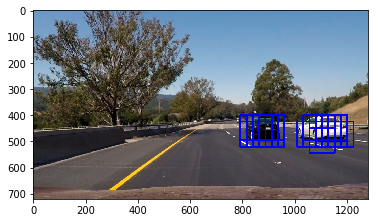

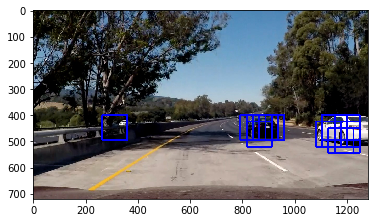

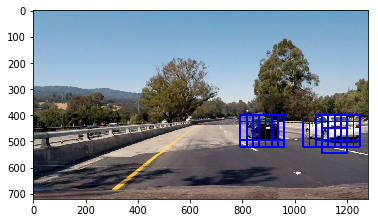

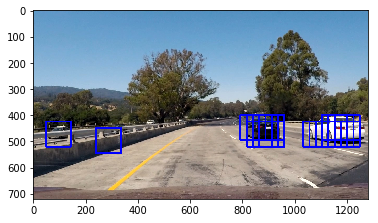

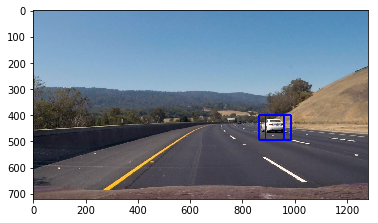

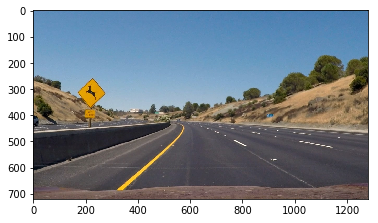

In [144]:
test_images = glob.glob('./test_images/*')
for test_image in test_images:
    
    img = mpimg.imread(test_image)


#     out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out_img = detector.find_cars(img)
    plt.imshow(out_img)
    plt.show()

In [152]:
class VehicleDetector(object):
    def __init__(self, ystart, ystop, scale, model, pix_per_cell, cell_per_block):
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale
        self.model = model

        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block

    
    
    # single function that can extract features using hog sub-sampling and make predictions
    def find_cars(self, img):

        ystart = self.ystart
        ystop = self.ystop
        scale = self.scale
        model = self.model

        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block

        
        draw_img = np.copy(img)
        img = img.astype(np.float32)/255

        img_tosearch = img[ystart:ystop,:,:]
        if scale != 1:
            imshape = img_tosearch.shape
            img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = img_tosearch[:,:,0]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step


        bboxes = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                subimg = subimg.reshape((1, subimg.shape[0], subimg.shape[1], subimg.shape[2]))
                
                test_prediction = model.predict(subimg)

                if test_prediction[0][1] > 0.75:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
#                     cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

                    bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
#         return draw_img
        return bboxes

        
    # function to draw the boxes with heatmap applied
    def draw_labeled_bboxes(self, img):
        
        _, labels = self.find_heatmap(img)
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img

    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    # function to find and return heatmap and labels
    def find_heatmap(self, img):
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        box_list = self.find_cars(img)
        # Add heat to each box in box list
        heat = self.add_heat(heat,box_list)
        # Apply threshold to help remove false positives
        heat = self.apply_threshold(heat,1)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        
        return heatmap, labels
    
ystart = 400
ystop = 656
scale = 1.5

detector = VehicleDetector(ystart, ystop, scale, model, pix_per_cell, cell_per_block)






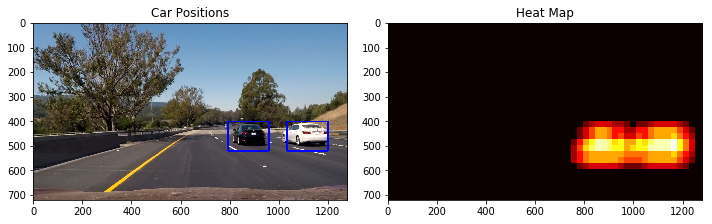

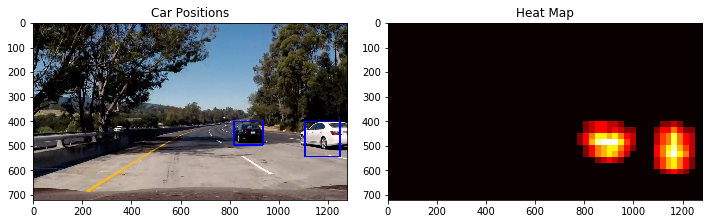

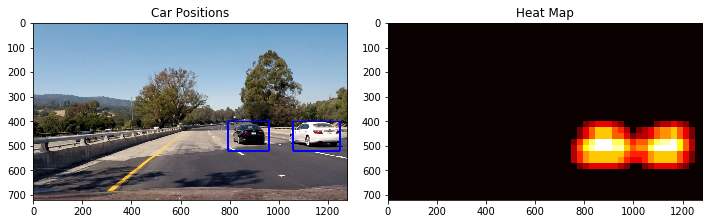

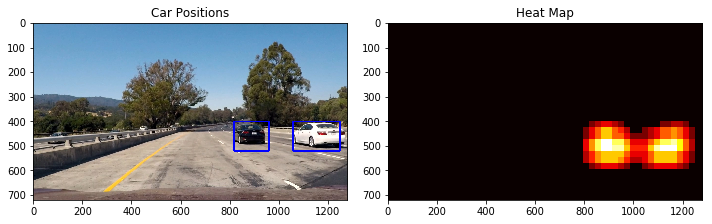

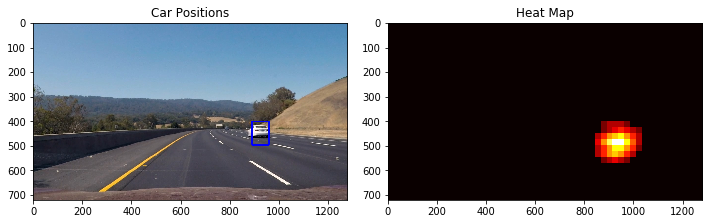

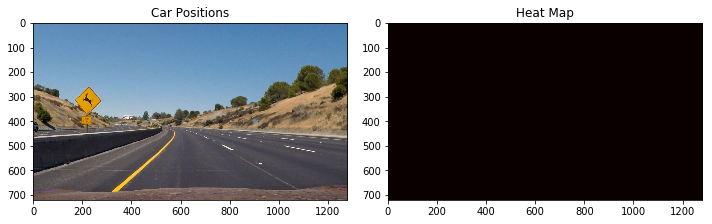

In [155]:
for test_image in test_images:
    
    img = mpimg.imread(test_image)



    draw_img = detector.draw_labeled_bboxes(img)
    heatmap, _ = detector.find_heatmap(img)

    fig = plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

In [157]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [158]:
# clip1 = VideoFileClip('./test_video.mp4')


clip1 = VideoFileClip('./project_video.mp4')

white_clip = clip1.fl_image(detector.draw_labeled_bboxes) 
output_video = 'ConvNet_output.mp4'
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ConvNet_output.mp4
[MoviePy] Writing video ConvNet_output.mp4


100%|█████████▉| 1260/1261 [16:41<00:00,  1.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ConvNet_output.mp4 

CPU times: user 25min 45s, sys: 2min 50s, total: 28min 36s
Wall time: 16min 42s


In [159]:
model.save('model.h5')